## Inference model outside Supervisely

**Install dependencies:**

In [ ]:
!pip install openmim==0.3.7
!mim install mmengine==0.7.4 mmcv==2.0.0 mmdet==3.0.0 "mmcls>=1.0.0rc0"

**After you have downloaded the model config and weights from Supervisely, put the paths here:**

In [16]:
# Put your paths here:
img_path = "demo_data/image_01.jpg"
config_path = "app_data/work_dir/config.py"
weights_path = "app_data/work_dir/epoch_8.pth"

device = "cuda:0"

**Build the model:**

In [17]:
import mmcv
from mmengine import Config
from mmdet.apis import inference_detector, init_detector

# build the model
cfg = Config.fromfile(config_path)
model = init_detector(cfg, weights_path, device=device, palette='random')

Loads checkpoint by local backend from path: tmp/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



**Get predictions:**

In [18]:
# predict
result = inference_detector(model, img_path)
print(result)

<DetDataSample(

    META INFORMATION
    batch_input_shape: (640, 640)
    pad_shape: (640, 640)
    img_id: 0
    ori_shape: (1080, 810)
    img_shape: (640, 640)
    scale_factor: (0.5925925925925926, 0.5925925925925926)
    img_path: 'demo_data/image_01.jpg'

    DATA FIELDS
    gt_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
        ) at 0x7f1c7a1088e0>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            scores: tensor([0.8521, 0.8354, 0.7557, 0.7401, 0.4576, 0.2885, 0.2687, 0.2278, 0.2271,
                        0.2202, 0.1959, 0.1892, 0.1858, 0.1830, 0.1812, 0.1724, 0.1705, 0.1699,
                        0.1687, 0.1686, 0.1616, 0.1590, 0.1532, 0.1524, 0.1496, 0.1483, 0.1440,
                        0.1413, 0.1387, 0.1354, 0.1347, 0.1339, 0.1321, 0.1315, 0.1306, 0.1305,
                        0.1303, 0.1282, 0.1261, 0.1255, 0.1246, 0.1237, 0.1233, 0.1218, 0.121

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


**Visualize predictions:**

In [19]:
from mmdet.registry import VISUALIZERS
from mmdet.visualization.local_visualizer import DetLocalVisualizer

# it's needed only for saving the resulting image on disk:
cfg.vis_backends[0]["save_dir"] = "vis"
model.cfg.visualizer["save_dir"] = "vis"

# create visualizer
visualizer: DetLocalVisualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer.dataset_meta = model.dataset_meta

/usr/local/lib/python3.8/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


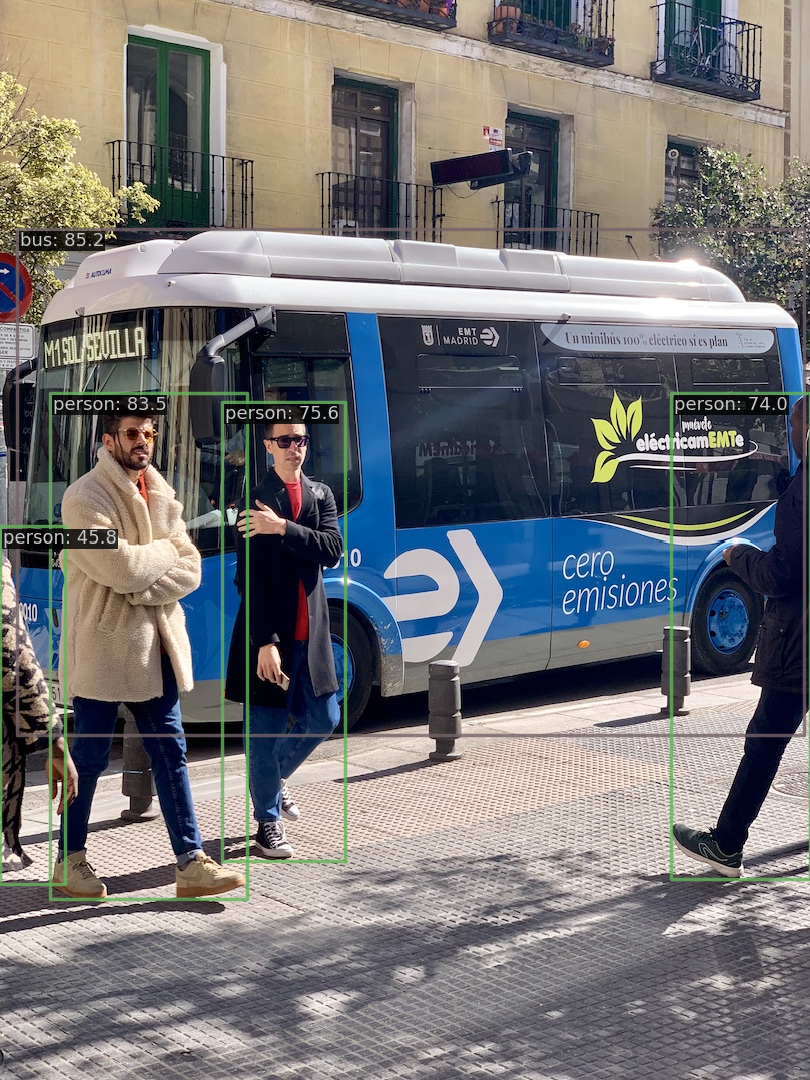

In [20]:
# visualize
img = mmcv.imread(img_path, channel_order="rgb")
visualizer.add_datasample(
    "result",
    img,
    data_sample=result,
    draw_gt=False,
    wait_time=0,
    show=False,
)
res_img = visualizer.get_image()

from PIL import Image
Image.fromarray(res_img)

**You can also collect and process predictions manually:**

In [23]:
from mmdet.structures import DetDataSample
from mmengine.structures import InstanceData

result: DetDataSample
preds = result.pred_instances.cpu().numpy()

# collect predictions
for pred in preds:
    pred: InstanceData
    confidence_score = float(pred.scores[0])
    class_idx = pred.labels.astype(int)[0]
    class_name = model.dataset_meta["classes"][class_idx]
    bbox = pred.bboxes[0].astype(int).tolist()
    if hasattr(pred, "masks"):
        mask = pred.masks[0]

    # process predictions
    # ...